### Feed-Forward Language Model with PyTorch
Exercise 5-6 from Neural Machine Translation and Sequence-to-sequence Models: A Tutorial by 
Graham Neubig (https://arxiv.org/abs/1703.01619)

In [10]:
# imports
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm import tqdm


# hidden layer width
H = 100
# embedding dimension
E = 50
# length of past-window
n = 3
# size of embedding vector, depends on feature function defined below
N = n*E

# load data
X_train = open("en-de/train.en-de.low.filt.en", "r", encoding="UTF-8").readlines()
X_test = open("en-de/test.en-de.low.en", "r", encoding="UTF-8").readlines()

In [4]:
# encode vocab as numerical index
padded_train = []
# automatically register new words to new consequitive ids
w2i = defaultdict(lambda: len(w2i))
# define special characters
S = w2i["<s>"]
END = w2i["</s>"]
UNK = w2i["<UNK>"]

# pad, split, and encode training data (taking subset to avoid dimensionality explosion)
for sentence in X_train[:1000]:
    padded_train.append([S]*n)
    for word in sentence.strip().split():
        padded_train[-1].append(w2i[word])
    padded_train[-1].append(END)

VOCAB = list(w2i.keys())
i2w = {v: k for k,v in w2i.items()}

# vocab length
V = len(VOCAB)

In [5]:
padded_test = []

# encode uknown words as UNK token
w2i.default_factory = lambda: UNK

# pad, split, and encode test data
for sentence in X_test:
        padded_test.append([S]*n + [w2i[word] for word in sentence.strip().split()] + [END])

In [80]:
class FFLM(nn.Module):
    def __init__(self):
        super(FFLM, self).__init__()
        
        # define the embedding layer
        self.embedding = nn.Embedding(V,E)
        # define the two fully-connected layers
        self.fc1 = nn.Linear(N,H)
        self.fc2 = nn.Linear(H,V)

    def forward(self, indices):

        # define forward pass, return scores
        x = self.embedding(indices)
        x = torch.flatten(x)
        x = self.fc1(x)
        x = torch.tanh(x)
        x = self.fc2(x)
        return x

def train(X):
    # initialize network, loss, optimizer   
    net = FFLM()
    # Cross Entropy loss combines softmax, log, and NLL
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=1e-4)
    running_loss = 0.0
    # for each word in the training data (except padding)
    for j, sentence in enumerate(tqdm(X)):
        for i in range(n+1, len(sentence)+1):
            input = torch.LongTensor(sentence[i-n-1:i-1])
            label = torch.LongTensor([sentence[i-1]])
            # zero parameter gradients
            optimizer.zero_grad()
            # forward pass
            scores = net(input).view(1,-1)
            # calculate loss
            loss = criterion(scores, label)
            # backward pass
            loss.backward()
            # take step
            optimizer.step()

        # print statistics
        running_loss += loss.item()
        if j % 100 == 99:
            print(f"{j+1}, loss: {running_loss / 100}")
            running_loss = 0.0
    
    # return trained model
    return net

In [81]:
net = train(padded_train)

 10%|█         | 100/1000 [00:30<04:46,  3.14it/s]

100, loss: 5.720907120704651


 20%|██        | 201/1000 [00:58<03:49,  3.47it/s]

200, loss: 1.55138625562191


 30%|███       | 300/1000 [01:31<03:50,  3.04it/s]

300, loss: 0.7542289109528064


 40%|████      | 400/1000 [02:01<03:27,  2.90it/s]

400, loss: 0.6277357091754675


 50%|█████     | 501/1000 [02:25<03:03,  2.72it/s]

500, loss: 1.065086120814085


 60%|██████    | 601/1000 [02:58<01:36,  4.14it/s]

600, loss: 1.1030938270688058


 70%|███████   | 700/1000 [03:35<01:50,  2.72it/s]

700, loss: 1.0827897578477859


 80%|████████  | 800/1000 [04:20<01:50,  1.80it/s]

800, loss: 1.0870680314302446


 90%|█████████ | 900/1000 [04:57<00:27,  3.61it/s]

900, loss: 1.1107256837189197


100%|██████████| 1000/1000 [05:28<00:00,  3.04it/s]

1000, loss: 0.4400615897774696


100%|██████████| 1565/1565 [00:39<00:00, 39.64it/s]


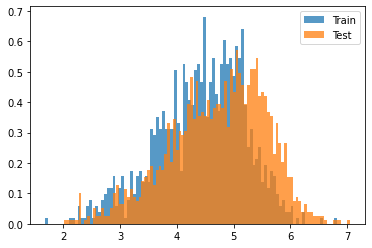

In [88]:
# score model on train and test sets
train_losses = []
test_losses = []
criterion = nn.CrossEntropyLoss()
# for each word in each sentence
for sentence in tqdm(padded_train):
    sentence_loss = 0
    # compute probability of word according to model
    for i in range(n+1,len(sentence)):
            input = torch.LongTensor(sentence[i-n-1:i-1])
            label = torch.LongTensor([sentence[i-1]])
            # calculate scores
            scores = net(input).view(1,V)
            # compute the loss
            sentence_loss += criterion(scores,label).item()
    # normalize by length of sentence
    train_losses.append(sentence_loss/len(sentence))

# as above
for sentence in tqdm(padded_test):
    sentence_loss = 0
    for i in range(n+1,len(sentence)):
            input = torch.LongTensor(sentence[i-n-1:i-1])
            label = torch.LongTensor([sentence[i-1]])
            scores = net(input).view(1,V)
            sentence_loss += criterion(scores,label).item()
    test_losses.append(sentence_loss/len(sentence))

# plot losses as histograms
_ = plt.hist(train_losses,100,density=True,alpha=0.75,label="Train")
_ = plt.hist(test_losses,100,density=True,alpha=0.75,label="Test")
plt.legend()
plt.show()

In [100]:
# define prediction functions

def greedy_search_step(net, past):
    # compute score vector and choose highest score
    input = torch.LongTensor(past)
    scores = net(input)
    # prevent choosing padding token
    scores[0] = 0
    return np.argmax(scores.detach().numpy())

def random_search_step(net, past):
    # compute score vector and sample from softmaxed distribution
    input = torch.LongTensor(past)
    scores = net(input)
    # prevent choosing padding token
    scores[0] = 0
    probs = torch.softmax(scores,0)
    return np.random.choice(range(V), p = probs.detach().numpy())

# predict sentence given seed and length
def search(net, seed, length, strat="greedy"):
    sentence = [w2i[word] for word in seed.split()]
    for _ in range(length):
        # halt if end sentence token is reached
        if sentence[-1] == END:
            return " ".join([i2w[i] for i in sentence])
        # predict next word
        if strat == "greedy":
            prediction = greedy_search_step(net, sentence[-n:])
        if strat == "random":
            prediction = random_search_step(net, sentence[-n:])
        # append to sentence
        sentence.append(prediction)
    return " ".join([i2w[i] for i in sentence])

In [103]:
# test generation

seed = "the little man had"
length = 10
print(search(net, seed, length, "greedy"))
print(search(net, seed, length, "random"))

the little man had and the 's of the , and the 's of
the little man had either in '' -- try into a three it was


In [105]:
seed = "the little woman had"
length = 10
print(search(net, seed, length, "greedy"))
print(search(net, seed, length, "random"))

the little woman had , and the 's of the , and the 's
the little woman had photographs not aspects up people has people , new look


fin.